In [43]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

Using TensorFlow backend.


In [39]:
data=pd.read_excel('Data.xlsx')

In [40]:
data.head()

,Date,Digital OI Leads,Digital OI Wins,leads to win Expression (Digital OI)
0,1,2399,747,0.311380
1,2,4474,700,0.156460
2,3,3117,691,0.221688
3,4,5150,889,0.172621
4,5,3720,1369,0.368011


In [41]:
data.describe()

,Date,Digital OI Leads,Digital OI Wins,leads to win Expression (Digital OI)
count,106.000000,106.000000,106.000000,106.000000
mean,53.500000,4131.518868,1304.575472,0.487890
std,30.743563,1389.188007,684.356256,1.195999
min,1.000000,56.000000,648.000000,0.106396
25%,27.250000,3335.000000,882.500000,0.201124
50%,53.500000,3956.500000,1039.500000,0.261772
75%,79.750000,4901.500000,1574.500000,0.448715
max,106.000000,10013.000000,3784.000000,12.000000


In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [29]:
resampled_data=data.shape
resampled_data

(106, 4)

In [51]:
# split into train and test sets
values = data.values
train_index = 500*24 #The logic is to have 500 days worth of training data. this could also be a hyperparameter that can be tuned.
train = values[:train_index, :]
test = values[train_index:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(106, 1, 3) (106,) (0, 1, 3) (0,)


Train on 106 samples, validate on 0 samples
Epoch 1/10
106/106 [==============================] - 2s 20ms/step - loss: 1.5674
Epoch 2/10
106/106 [==============================] - 0s 896us/step - loss: 1.4772
Epoch 3/10
106/106 [==============================] - 0s 532us/step - loss: 1.4044
Epoch 4/10
106/106 [==============================] - 0s 764us/step - loss: 1.3331
Epoch 5/10
106/106 [==============================] - 0s 541us/step - loss: 1.2681
Epoch 6/10
106/106 [==============================] - 0s 612us/step - loss: 1.1961
Epoch 7/10
106/106 [==============================] - 0s 644us/step - loss: 1.1348
Epoch 8/10
106/106 [==============================] - 0s 790us/step - loss: 1.0764
Epoch 9/10
106/106 [==============================] - 0s 632us/step - loss: 1.0203
Epoch 10/10
106/106 [==============================] - 0s 554us/step - loss: 0.9666


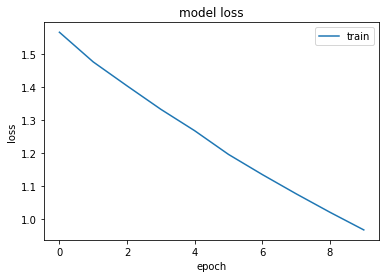

In [52]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dropout(0.2))
model.add(LSTM(50))
#model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=20, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [53]:
# make a prediction
yhat = model.predict(test_X, verbose=2)
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

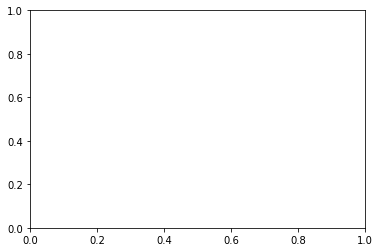

In [50]:
aa=[x for x in range(100)]
plt.plot(aa, test_y[:100], marker='.', label="actual")
plt.plot(aa, yhat[:100], 'r', label="prediction")
plt.ylabel('Digital of Wins', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=13)
plt.show()